# Evaluation of 1D CNN

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import time
import torch
from torch.utils.data import DataLoader
sys.path.insert(0,'../')
from utils import *
import seaborn as sns
import matplotlib.pyplot as plt
# from models import SqueezeNet
from dataset import CNN1dDataset
from trainable_model import TrainableModel
from data_interface import *
import metrics

import TransfomerModel

In [3]:
plt.rcParams.update({
    'text.usetex': True,                      # Use LaTeX for text rendering
    'font.family': 'serif',                   # Use serif fonts like in MATLAB
    'figure.dpi': 300,                        # High resolution for figures
    'savefig.dpi': 300,                       # High resolution for saving
    'figure.figsize': (6, 4),                 # Set figure size (inches)
    'axes.labelsize': 14,                     # Axis label font size
    'axes.titlesize': 16,                     # Title font size
    'font.size': 12,                          # Global font size
    'legend.fontsize': 12,                    # Legend font size
    'xtick.labelsize': 12,                    # X-tick label size
    'ytick.labelsize': 12,                    # Y-tick label size
    'lines.linewidth': 2,                     # Line width
    # 'lines.markersize': 6,                    # Marker size
    'grid.linestyle': '--',                   # Dashed grid lines
    'grid.alpha': 0.7,                        # Grid line transparency
    'axes.grid': False,                       # Show grid by default
    'axes.edgecolor': 'black',                # Black edges around axes
    'axes.linewidth': 1.0,                    # Axis line width
    'xtick.direction': 'in',                  # Inward ticks
    'ytick.direction': 'in',                  # Inward ticks
    'legend.frameon': False,                  # No frame around legend
    'axes.prop_cycle': plt.cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
})  # Color cycle similar to MATLAB's default colors


In [4]:
# Set device 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
print(device)

cpu


In [5]:
torch.set_default_dtype(torch.float64)
# Load data
path = '../intracardiac_dataset/'
VmTrainData, pECGTrainData, VmDataTest, pECGTestData, actTimeTrain, actTimeTest  = fileReader(path, 16117, 0.8)
print('Data loading from files - complete')

data_scaling_ecg = 'normalized_unit'
data_scaling_vm = 'normalization'
num_timesteps = 500 #500
all_channels = True
input_dim = 12
output_dim = 75
batch_size = 32
test_batch_size = 1

# 80 -10 -10 split 
TrainData = CNN1dDataset(VmTrainData, pECGTrainData, num_timesteps=num_timesteps, 
                         scaling_ecg=data_scaling_ecg,scaling_vm=data_scaling_vm)
data_split = -117 #VmDataTest.shape[0]//2
ValData = CNN1dDataset(VmDataTest[:data_split], pECGTestData[:data_split],num_timesteps=num_timesteps, 
                         scaling_ecg=data_scaling_ecg,scaling_vm=data_scaling_vm)
TestData = CNN1dDataset(VmDataTest[data_split:], pECGTestData[data_split:],num_timesteps=num_timesteps, 
                         scaling_ecg=data_scaling_ecg,scaling_vm=data_scaling_vm)
print('Data normalization - complete')

# Define data loader
dataloaders = {}
dataloaders['train'] = DataLoader(TrainData, test_batch_size)
dataloaders['val'] = DataLoader(ValData, test_batch_size)
dataloaders['test'] = DataLoader(TestData, test_batch_size)

Loading datafiles : 100%|█████████████████████████████████████████| 16117/16117 [01:53<00:00, 141.98it/s]


Data loading from files - complete
Data normalization - complete


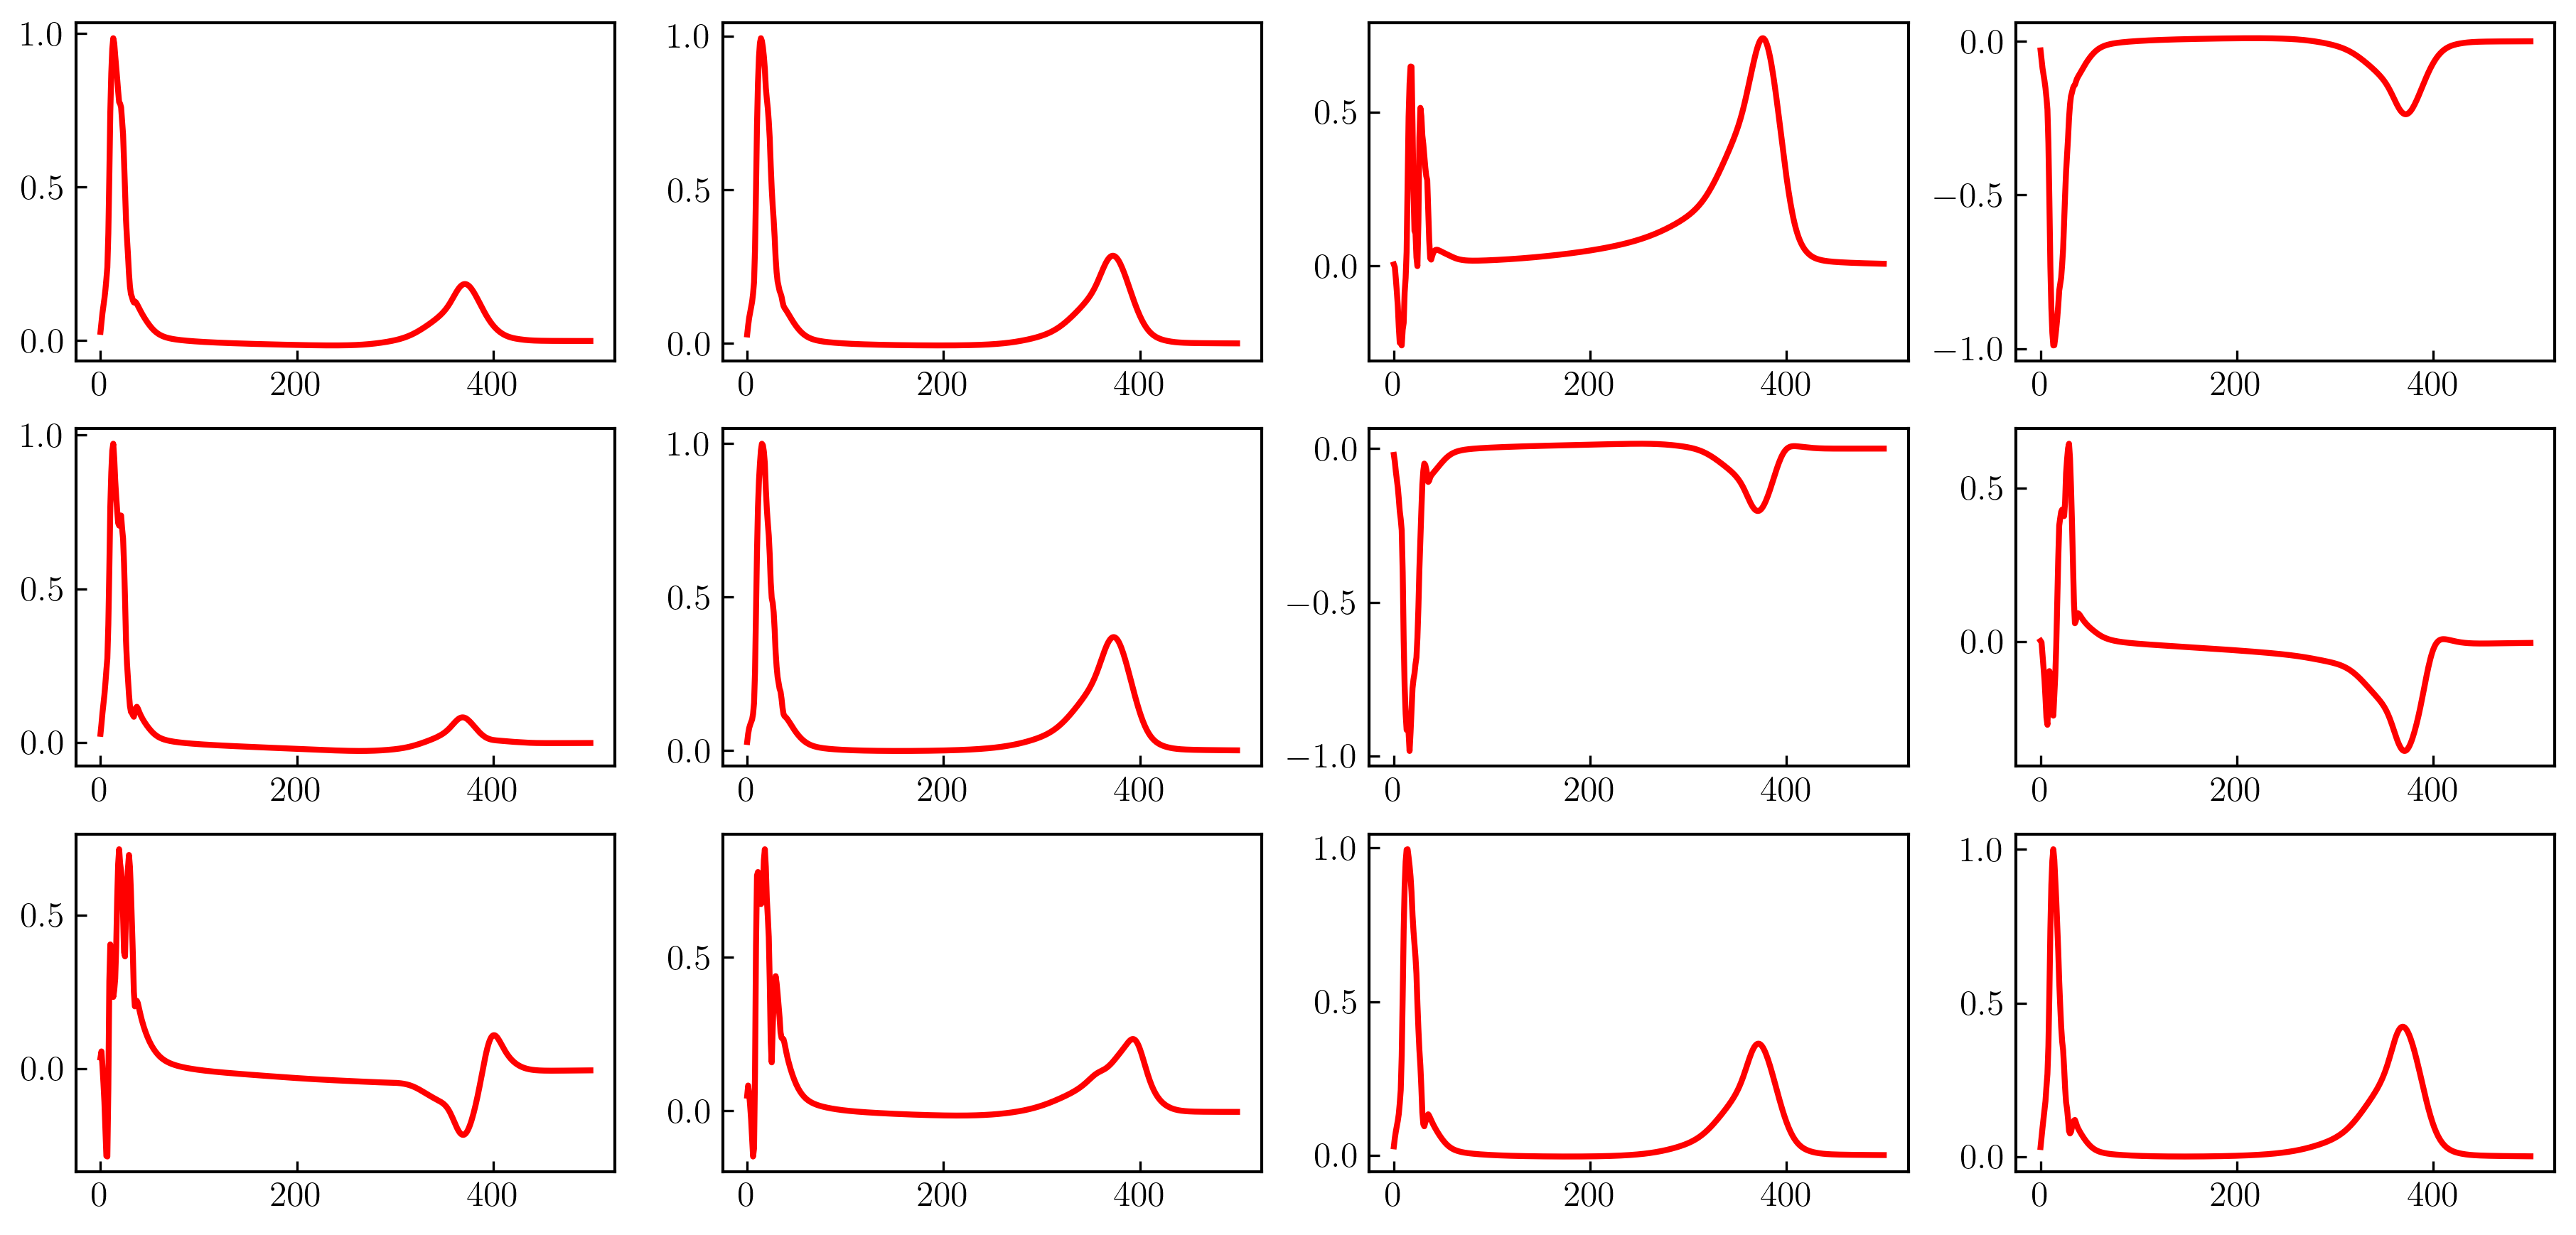

In [6]:
fig, axs = plt.subplots(3,4, figsize=(15,7))
axs = axs.ravel()
for i in range(12):
    axs[i].plot(TrainData[2][0][i], color='r')
    axs[i].plot(TrainData.ECGData[2].T[i], color='r', linewidth=0.5, linestyle='dashed')

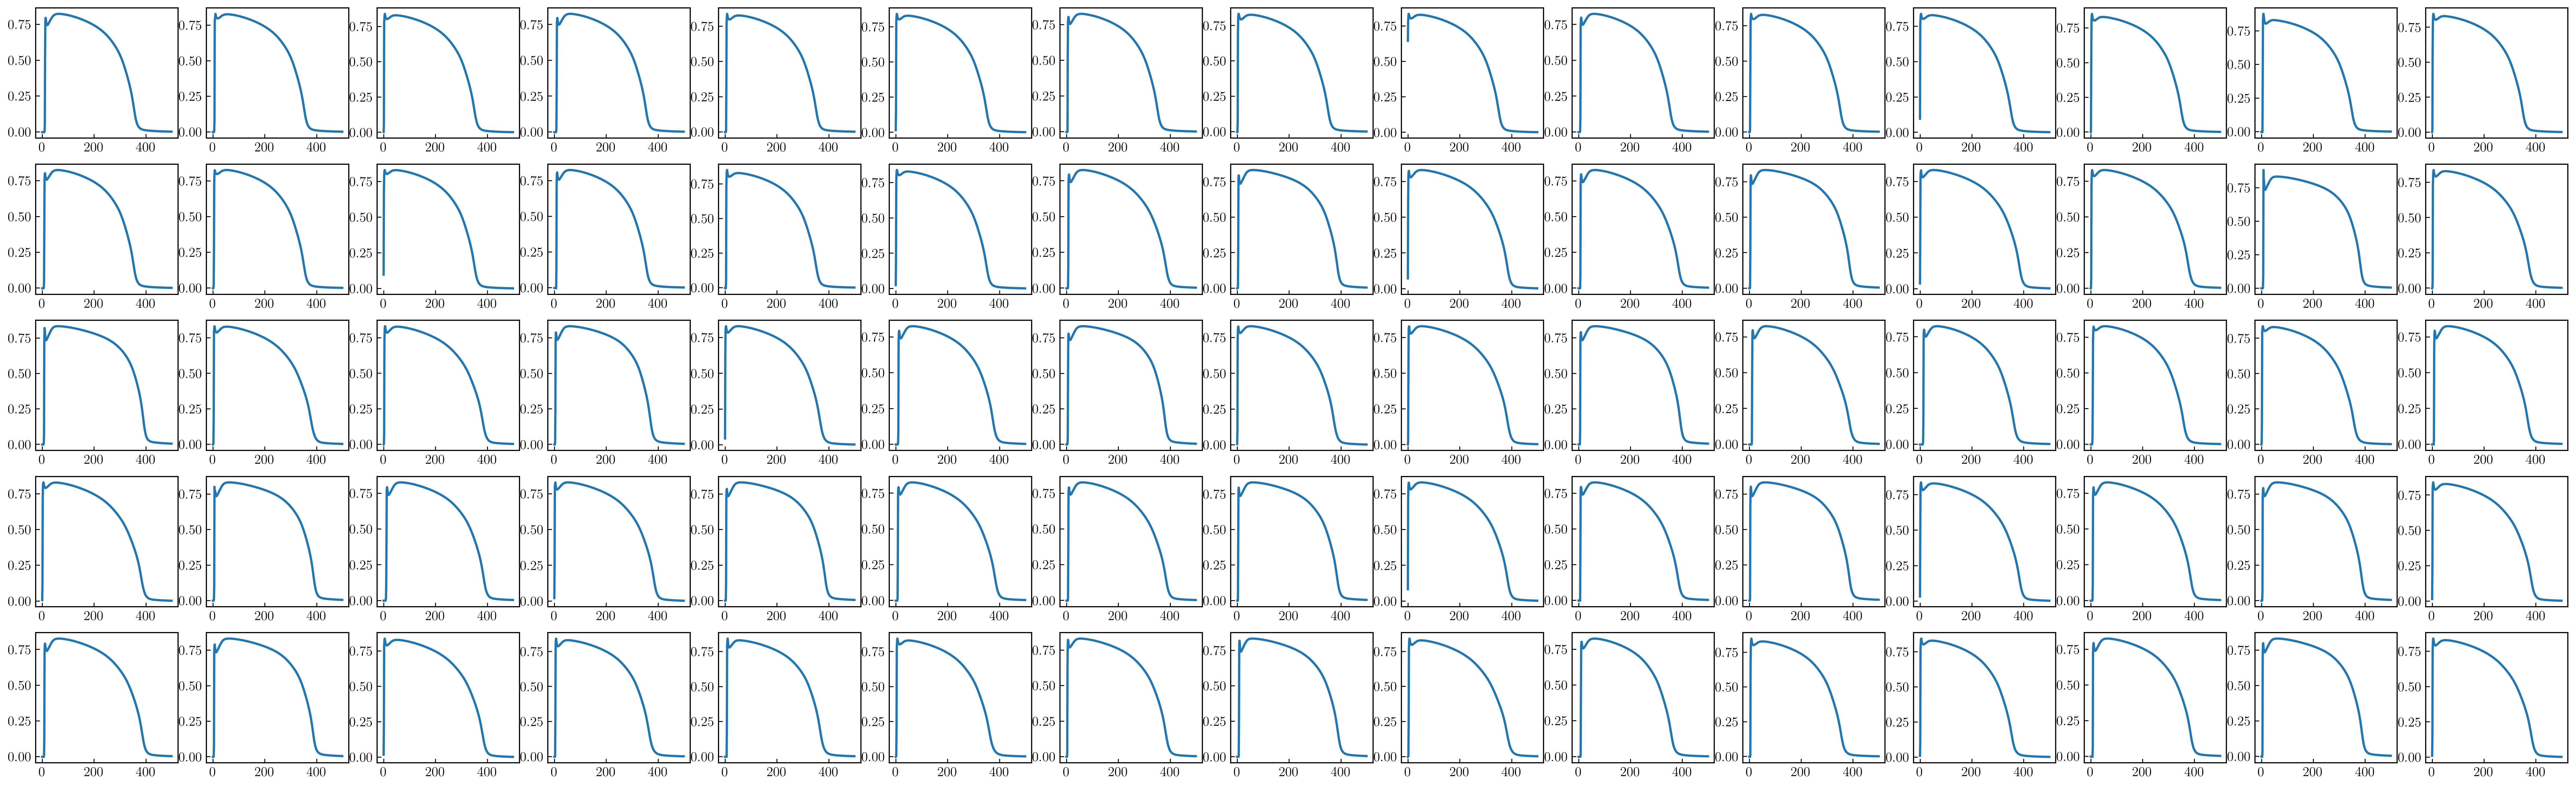

In [7]:
fig, axs = plt.subplots(5,15, figsize=(40,12))
axs = axs.ravel()
for i in range(75):
    axs[i].plot(TrainData[2][1][i])

# Evaluate

In [8]:
def build_eval_meter():
    metric_dict = {}
    for metric_name in METRICS.keys():
        metric_dict[metric_name] = METRICS[metric_name]()

    main_metric = 'rmse'
    return metrics.Meter(metric_dict, main_metric)

In [9]:
# 1D CNN eval
model_str = '../models/cnnModel_v1_1.best.pth'
model = torch.load(f'./{model_str}', map_location=torch.device(device))
model.to(device)

output_dir = '../CNN1D-results/'
dataloader = dataloaders.get('test')
num_batches = len(dataloader)
model.eval()

mode = 'test'
save_dir = '../cnn_results/'

/var/folders/c_/ryp6y6k53ss049db0ng9scw80000gn/T/ipykernel_5047/2461334910.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f'./{model_str}', map_locat

In [10]:
# Transformer loading
model_params = {
    "enc_drop": 0.2,
    "dec_drop": 0.2,
    "heads": 75,
    "dim_val": 75,
    "enc_layers": 4,
    "dec_layers": 4,
    "enc_feed": 128,
    "dec_feed": 128,
    "batch_first": True,
    "steps": 10, # same as start/step_size in data
    }
transformer = TransfomerModel.SelfTimeSeriosTransformer(
    in_channels=12,
        out_channels=75,
        loss_fn=None,
        **model_params
    )
best_transformer_dict = torch.load('../TRANSFORMER-20240903-013603-877428-6jua1ycn/best_model.pth', map_location=torch.device(device))

# Remove 'module.' prefix from state dict keys
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in best_transformer_dict['model_state_dict'].items():
    name = k.replace('module.', '')  # remove `module.` from key
    new_state_dict[name] = v

# Load the new state dict into your model
transformer.load_state_dict(new_state_dict)
transformer.eval()

/var/folders/c_/ryp6y6k53ss049db0ng9scw80000gn/T/ipykernel_5047/3820147820.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_transformer_dict = torch.load('../TRANSF

SelfTimeSeriosTransformer(
  (encoder_input_layer): Sequential(
    (0): Conv1d(12, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv1d(64, 16, kernel_size=(1,), stride=(1,))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv1d(16, 64, kernel_size=(1,), stride=(1,))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv1d(16, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv1d(128, 16, kernel_size=(1,), stride=(1,))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv1d(16, 64, kernel_size=(1,), stride=(1,))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv1d(16, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): 

In [12]:
METRICS = {
    "r2": metrics.R2,
    "mae": metrics.MAE,
    "mse": metrics.MSE,
    "rmse": metrics.RMSE,
    "pearson_r": metrics.PearsonR,
    "spearman_r": metrics.SpearmanR,
}

In [13]:
eval_meter = build_eval_meter()

test_predictions = []
test_targets = []
metric_vals = {}
# predictions = {}
with torch.no_grad():
    for i, (inputs,labels) in enumerate(dataloader):
        pred = model(inputs)   
    # plt.plot(results[0][0].cpu().detach())
    # plt.plot(labels[0][0].cpu().detach())
        metric_vals.update({f'{16000+i}': eval_meter.update(pred, labels)})
   


In [45]:
batch = {'x': inputs[:,:,:model_params['steps']], 'y': labels.permute(0,2,1)}
t_pred = transformer(batch)

In [46]:
t_pred.shape

torch.Size([1, 500, 10, 75])

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame.from_dict(metric_vals, orient='index')
df

In [ ]:
sns.boxplot(df)

In [ ]:
torch.set_default_dtype(torch.float64)
# Load data
path = './intracardiac_dataset/'
VmTrainData, pECGTrainData, VmDataTest, pECGTestData, actTimeTrain, actTimeTest  = fileReader(path, 16140, 0.8)
print('Data loading from files - complete')

VmTrainData = (VmTrainData - torch.min(VmTrainData))/(torch.max(VmTrainData) - torch.min(VmTrainData))
pECGTrainData = (pECGTrainData - torch.min(pECGTrainData))/(torch.max(pECGTrainData) - torch.min(pECGTrainData))

VmDataTest = (VmDataTest - torch.min(VmDataTest))/(torch.max(VmDataTest) - torch.min(VmDataTest))

pECGTestData = (pECGTestData - torch.min(pECGTestData))/(torch.max(pECGTestData) - torch.min(pECGTestData))
print('Normalization - complete!')

In [ ]:
data_scaling_ecg = 'normalized_unit'
data_scaling_vm = 'normalization'
num_timesteps = 500
all_channels = True
input_dim = 12
output_dim = 75
outLead = [i for i in range(output_dim)]
dataset = Ecg2VmDataset(file_pairs[:10], outLead, num_timesteps, 
              scaling_ecg= data_scaling_ecg, scaling_vm= data_scaling_vm, 
              noise_ecg= 'none', noise_vm= 'none')

In [ ]:
# 80 -10 -10 split 
TrainData = CNN1dDataset(VmTrainData, pECGTrainData)
data_split = VmDataTest.shape[0]//2
ValData = CNN1dDataset(VmDataTest[:data_split], pECGTestData[:data_split])
TestData = CNN1dDataset(VmDataTest[data_split:], pECGTestData[data_split:])

In [ ]:
model = SqueezeNet(version='1_1')

In [ ]:
learning_rate = 1e-3
gamma_scheduler = 1.0
step_size_scheduler = 100
batch_size = 32
num_epochs = 1000
grad_clippling = False
dropout = 0.0
# loss_norm = MSE
load_model = False
model_path = '../cardiac-ai/model.pth'#./mymodel.training.epoch.1400.pth

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size_scheduler,gamma=gamma_scheduler)
outputHandler = '../cardiac-ai/trainingStats'
# Define data loader
dataloader = DataLoader(TrainData, batch_size, shuffle=True)
val_loader = DataLoader(ValData, batch_size)